# Analyse processed Google Trends time series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
import math
import os
import statsmodels.api as sm
import statsmodels.graphics as smg
import warnings

### Data import

In [2]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)


countries = list(assignment_language_country.keys())

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

## Define plot and analysis functions


### Time series plot

In [3]:
def plot_single_timeseries(df, col, w_err_band=True, ax=None):
    df.plot(y=("mean", col), ax=ax, legend=False)
    if w_err_band:
        if ax is None:
            ax = plt
        ax.fill_between(
            df.index,
            df["mean", col] - df["sem", col],
            df["mean", col] + df["sem", col],
            alpha=0.5,
        )


def plot_timeseries(dfs, k_id, countries, w_err_band=True, n_cols=3):
    n_rows = math.ceil(len(countries) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                country = countries[i * n_cols + j]
                ts = dfs[country]
                ax = axs[i, j]
                plot_single_timeseries(ts, k_id, ax=ax, w_err_band=w_err_band)
                ax.set_title(country)
            except ValueError:
                pass

    fig.suptitle("Keyword ID " + k_id, fontsize=32)
    plt.tight_layout()

    return fig


### ACF/PACF plot

In [4]:
def plot_autocorrelation(
    dfs, k_id, countries, type="acf", n_cols=3, n_lags=24, title="ACF"
):

    n_rows = math.ceil(len(countries) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                ax = axs[i, j]
                country = countries[i * n_cols + j]

                ts = dfs[country]["mean", k_id]
                if type == "acf":
                    smg.tsaplots.plot_acf(ts, ax=ax, lags=n_lags)
                elif type == "pacf":
                    smg.tsaplots.plot_pacf(ts, ax=ax, lags=n_lags)

                ax.set_title(country)
            except np.linalg.LinAlgError:
                warnings.warn("LinAlgError produced for country " + country)
                pass

    fig.suptitle(title + " Keyword ID " + k_id, fontsize=32)
    plt.tight_layout()
    return fig



### ADF Test

In [30]:
def test_adf(dfs, k_id, countries, n_lags=None):

    adf_values, p_values = [], []

    for c in countries:
        ts = dfs[c]["mean", k_id]
        test_results = sm.tsa.stattools.adfuller(ts, maxlag=n_lags)

        adf_values.append(test_results[0])
        p_values.append(test_results[1])

    df_results = pd.DataFrame({"country": countries,"adf": adf_values,"p": p_values})

    return df_results



## Transformation and exemplary analysis

In [35]:
keyword_ids = dataframes[countries[0]].columns.get_level_values(1)
dfs_transformed = {c: dataframes[c].diff()[1:] for c in countries}

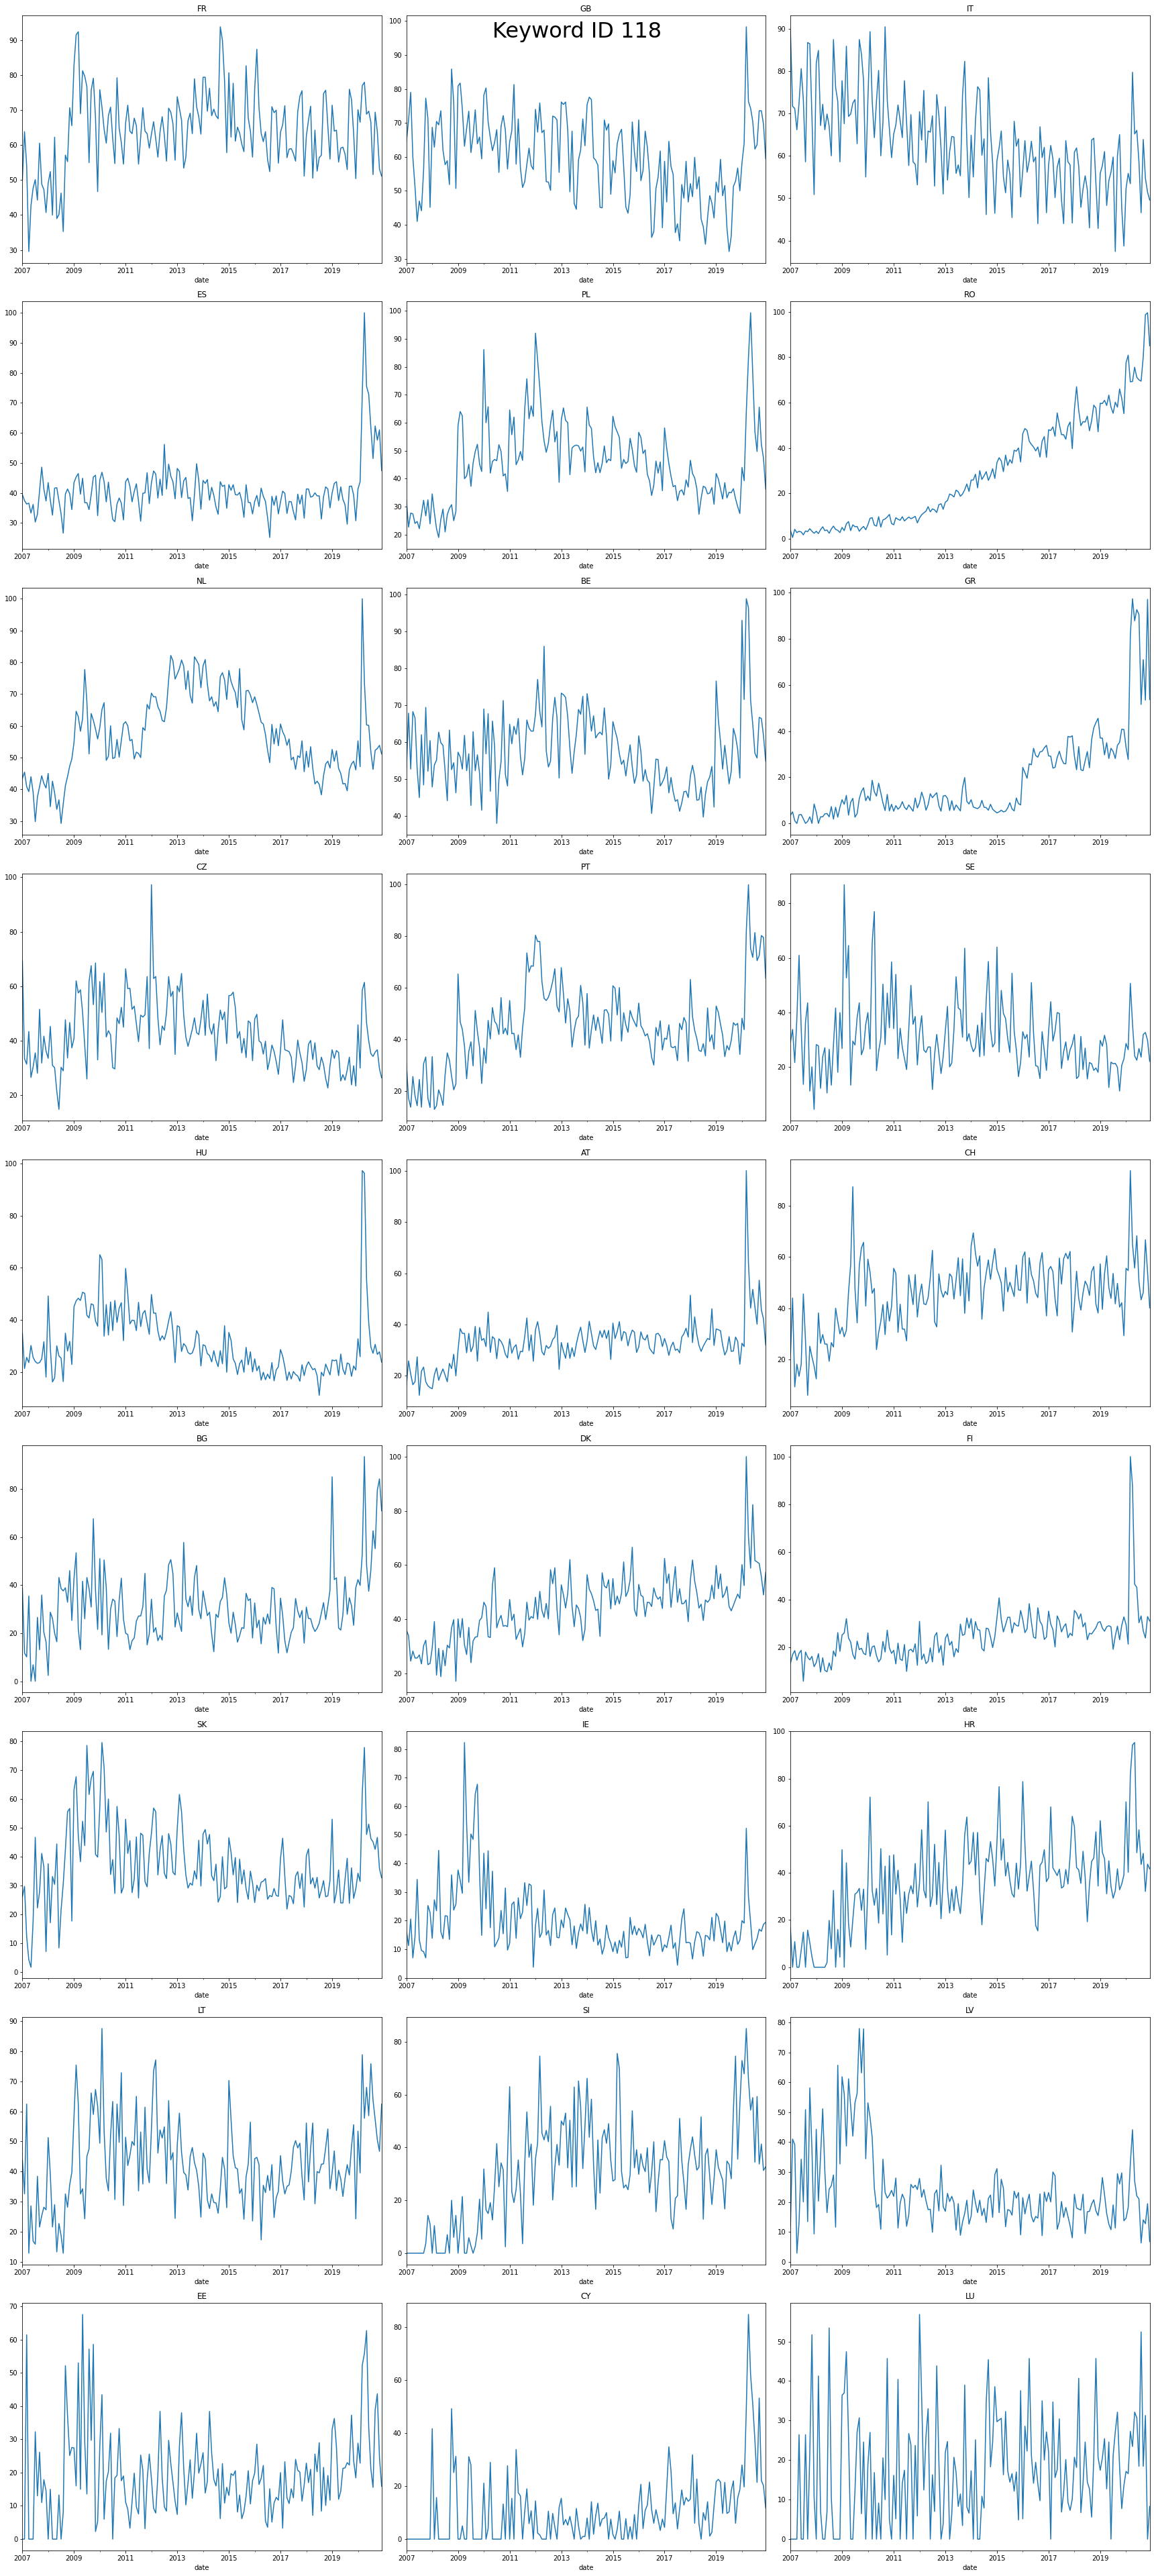

In [50]:
fig = plot_timeseries(dataframes, "118", countries, w_err_band=False)
fig.show()


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


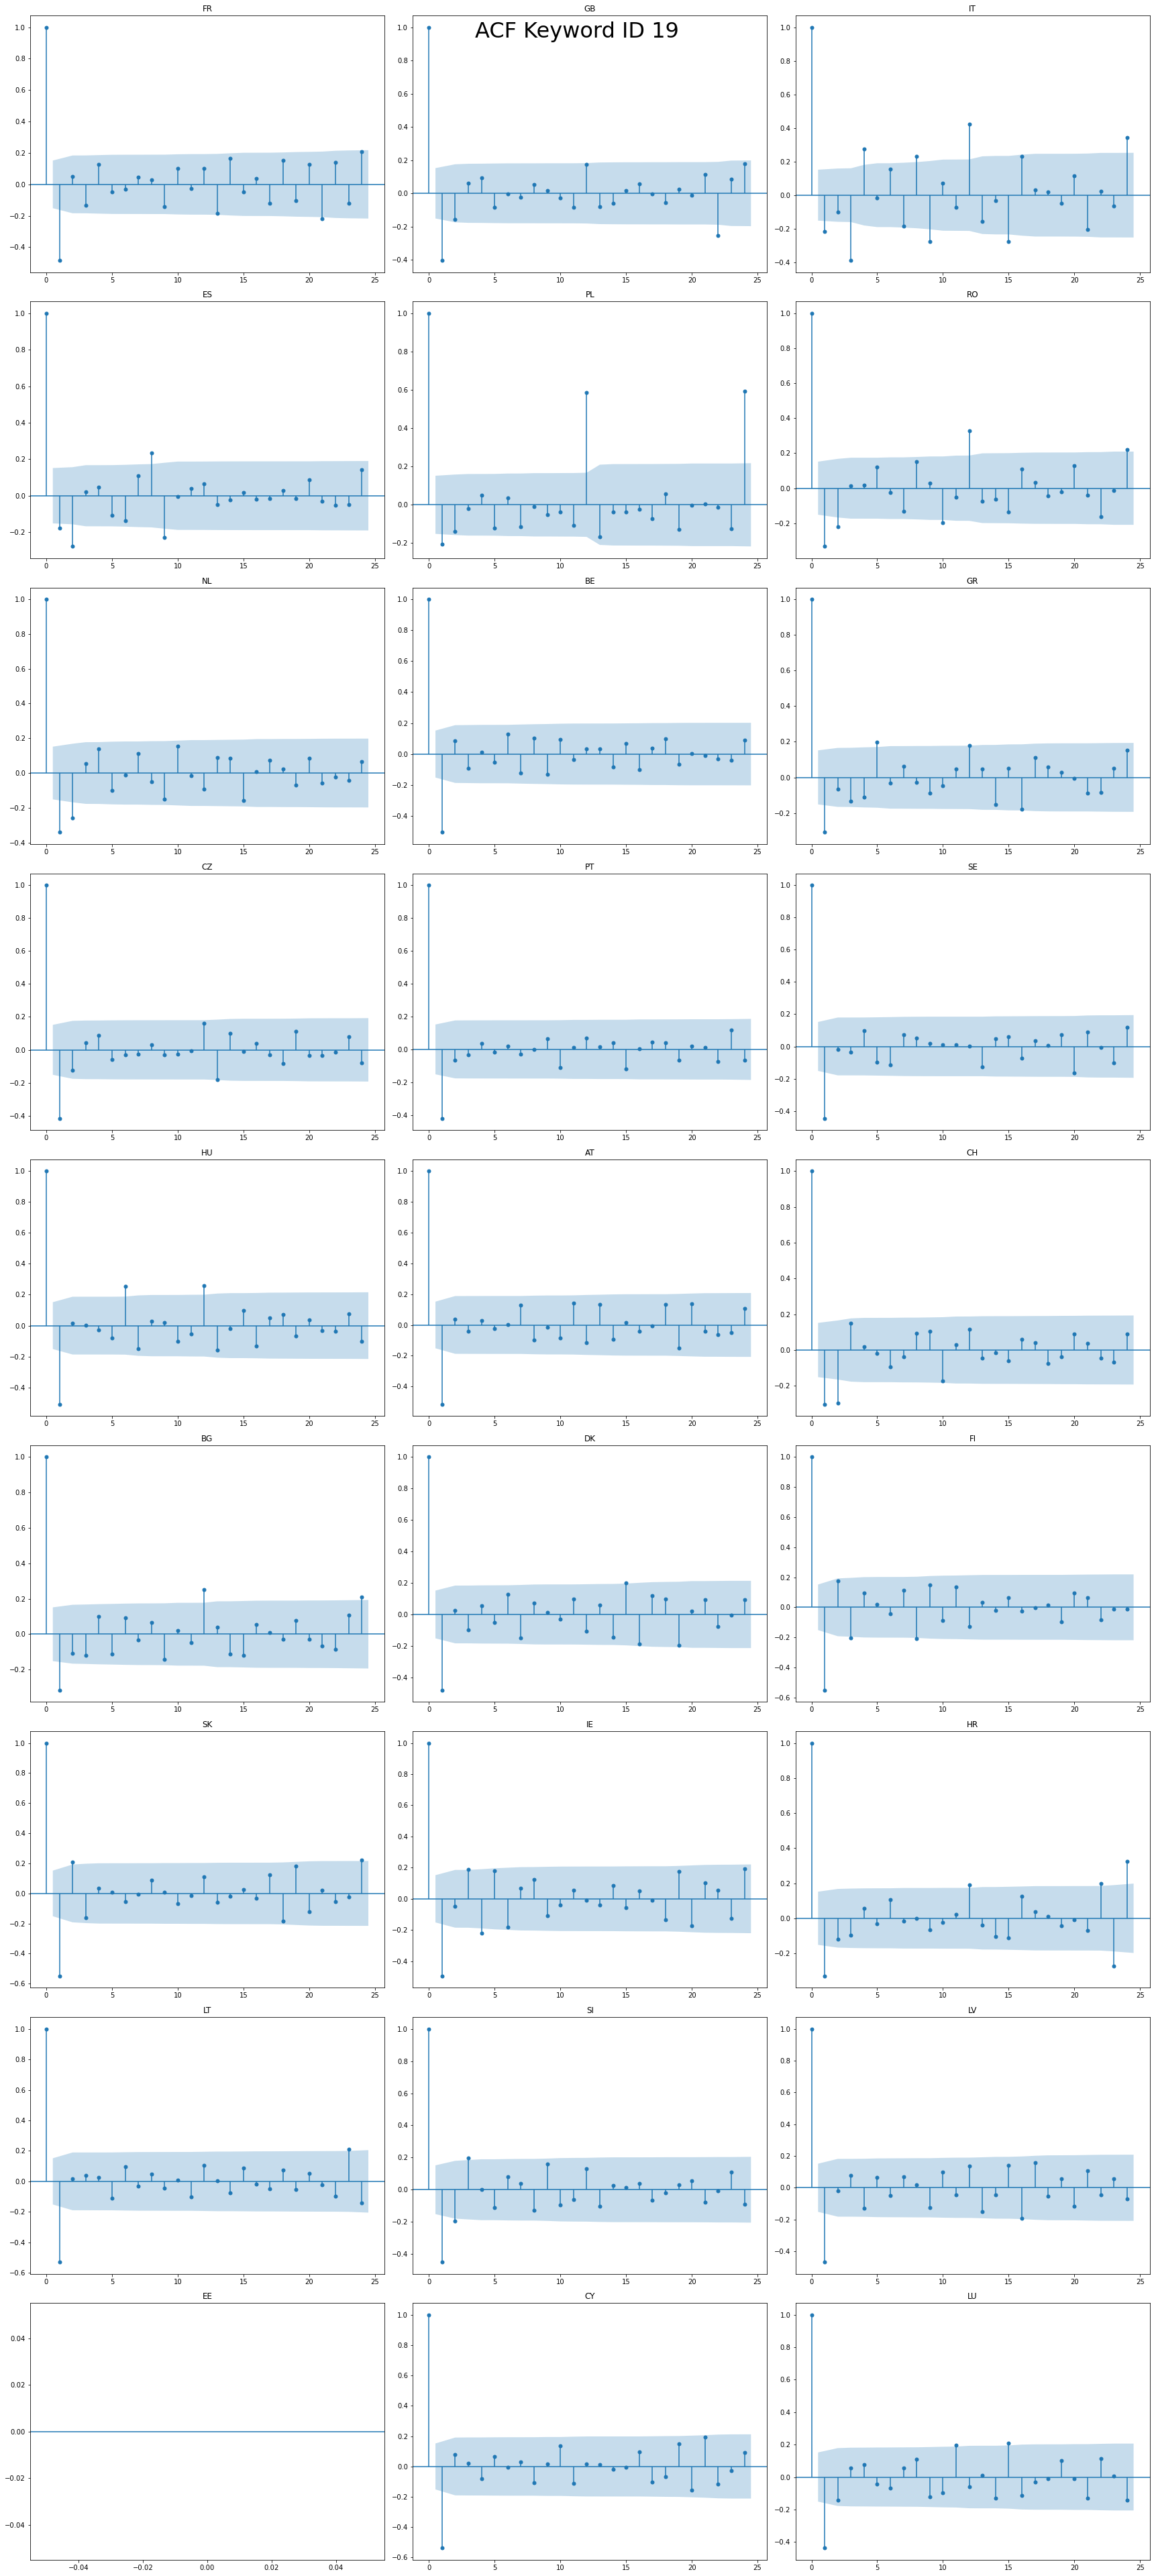

In [24]:

plot_autocorrelation(dfs_transformed, "19", countries, type="acf")
plt.show()


In [32]:
test_adf(dfs_transformed, "19", countries)

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


,country,adf,p
0,FR,-6.475886,1.331544e-08
1,GB,-6.791373,2.359990e-09
2,IT,-2.655917,8.198201e-02
3,ES,-6.193336,6.048116e-08
4,PL,-3.774835,3.175539e-03
5,RO,-7.594071,2.487121e-11
6,NL,-8.482438,1.381518e-13
7,BE,-7.284741,1.468856e-10
8,GR,-2.316201,1.667962e-01
9,CZ,-7.565948,2.925611e-11


## Batch analysis

### Time series

In [ ]:
keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

for k_id in tqdm(keyword_ids):

    fig = plot_timeseries(dataframes, k_id, countries)
    plt.savefig("plots/timeseries_kwid_" + k_id + ".png")
    plt.close()


### ACF/PACF

In [ ]:
keyword_ids = dataframes[countries[0]].columns.get_level_values(1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k_id in tqdm(keyword_ids):
        plot_autocorrelation(
            k_id,
            countries,
            type="acf",
            title="ACF Differentiated",
        )
        plt.savefig("plots/trends_acf_diff_kwid_" + k_id + ".png")
        plt.close()
        plot_autocorrelation(
            k_id,
            countries,
            type="pacf",
            title="ACF Differentiated",
        )
        plt.savefig("plots/trends_pacf_diff_kwid_" + k_id + ".png")
        plt.close()

# plt.savefig("plots/timeseries.png")


### ADF Test

In [42]:
results = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for k_id in tqdm(keyword_ids):
        results.append(test_adf(dfs_transformed, k_id, countries).assign(k_id = k_id))

df_adf = pd.concat(results)


100%|██████████| 96/96 [00:34<00:00,  2.82it/s]


In [45]:
df_adf[df_adf.p > 0.05]

,country,adf,p,k_id
2,IT,-2.655917,0.081982,19
8,GR,-2.316201,0.166796,19
2,IT,-2.005243,0.284279,28
5,RO,-0.372755,0.914549,118
6,NL,-2.857102,0.050569,118
0,FR,-2.081111,0.252177,119
4,PL,-2.687864,0.076162,119
20,HR,-2.631518,0.086657,119
22,SI,-2.760223,0.064184,119
12,HU,-2.272319,0.181051,123
